# Projeto de Aprendizagem Automática II

## Procura de Exoplanetas no Espaço através da Emissão de Luz de Estrelas

### Importação de Bibliotecas

In [1]:
import pandas as pd 
import numpy as np  

import matplotlib            
import matplotlib.pyplot as plt

import seaborn as sns        
color = sns.color_palette()
sns.set_style('darkgrid')

import os

from random import randint
from scipy.stats import randint as sp_randint

from time import time
from datetime import datetime

import sklearn               
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, VarianceThreshold, chi2

from warnings import simplefilter

%matplotlib inline
simplefilter(action='ignore', category=FutureWarning)

### Carregamento dos Dados

In [3]:
treino = pd.read_csv("../../../../Dados/dados_treino.csv")
teste = pd.read_csv("../../../../Dados/dados_teste.csv")

O primeiro passo é a preparação dos dados para o tipo de rede que se está a criar. Assim, além da divisão entre atributos e *labels*, a variável de decisão deve ser categorizada. Além disso, tendo em conta o formato de entrada dos dados numa rede *LSTM*, os registos têm que estar no formato **(sistemas, features, observações)**. Tendo em conta que apenas se está a lidar com uma *feature*, sendo esta o valor de *flux* ao longo do tempo, o formato gerado tem que ser **(sistemas, 1, observações)**.
É, ainda, importante realçar a divisão do conjunto de treino em dois conjuntos: treino e validação, sendo o último utilizado como medida de validação do modelo.

In [4]:
from keras.utils.np_utils import to_categorical
Y = treino['LABEL']
X = treino.loc[:, treino.columns != 'LABEL']
x_train = X.values.reshape(X.shape[0], 1, X.shape[1])

# One Hot Encoding
y_train = to_categorical(Y.values)
y_train = y_train[:, 1:]

train, validation, train_target, validation_target = train_test_split(x_train, y_train, test_size=0.2, random_state=1)

Using TensorFlow backend.


Como mencionado, é visível que o conjunto de treino possui, agora, o formato desejado, tendo apenas uma *feature* em estudo.

In [5]:
x_train.shape

(6565, 1, 3198)

### Modelo

No que toca ao modelo, numa fase inicial, foi apenas utilizada uma camada de *LSTM*, em que o número de unidades de memória é 848. No que toca à camada de saída, esta trata-se de uma camada *Dense* com dois nodos, sendo cada um destes associado a uma das classes possíveis da variável de saída.

In [6]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

model = Sequential()
# 848 Unidades de Memória
model.add(LSTM(848, input_shape=(x_train.shape[1], x_train.shape[2])))
# 2 Nodos de Saída
model.add(Dense(2, activation='softmax'))

Observando o sumário do modelo, são visíveis as duas camadas previamente definidas, bem como o formato dos seus *outputs* e número de parâmetros.

In [7]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 848)               13727424  
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1698      
Total params: 13,729,122
Trainable params: 13,729,122
Non-trainable params: 0
_________________________________________________________________


Em seguida é apresentada uma visualização gráfica do modelo definido.

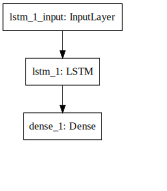

In [8]:
import keras
import pydot as pyd
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

keras.utils.vis_utils.pydot = pyd

#Visualize Model
def visualize_model(model):
  return SVG(model_to_dot(model).create(prog='dot', format='svg'))

visualize_model(model)

### Treino

No que toca ao otimizador do modelo foi utilizado *Adam*, com *learning rate* de 0.001. Além disso, foi utilizado um *checkpoint* em que este monitoriza a *accuracy* do conjunto de validação, armazenando os pesos do modelo no ponto em que esta métrica é máxima. Além disso, é guardado um histórico do treino, permitindo a visualização da evolução das métricas.

In [10]:
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
adam = Adam(lr=0.001)
chk = ModelCheckpoint('best_model.pkl', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
history = model.fit(train, train_target, epochs=200, batch_size=128, callbacks=[chk], validation_data=(validation,validation_target))

Train on 5252 samples, validate on 1313 samples
Epoch 1/200
5252/5252 [==============================] - 16s 3ms/step - loss: 0.0219 - accuracy: 0.9941 - val_loss: 0.0528 - val_accuracy: 0.9810

Epoch 00001: val_accuracy improved from -inf to 0.98096, saving model to best_model.pkl
Epoch 2/200
5252/5252 [==============================] - 14s 3ms/step - loss: 0.0349 - accuracy: 0.9916 - val_loss: 0.0371 - val_accuracy: 0.9893

Epoch 00002: val_accuracy improved from 0.98096 to 0.98934, saving model to best_model.pkl
Epoch 3/200
5252/5252 [==============================] - 14s 3ms/step - loss: 0.0305 - accuracy: 0.9928 - val_loss: 0.0554 - val_accuracy: 0.9916

Epoch 00003: val_accuracy improved from 0.98934 to 0.99162, saving model to best_model.pkl
Epoch 4/200
5252/5252 [==============================] - 15s 3ms/step - loss: 0.0453 - accuracy: 0.9935 - val_loss: 0.0535 - val_accuracy: 0.9901

Epoch 00004: val_accuracy did not improve from 0.99162
Epoch 5/200
5252/5252 [================

5252/5252 [==============================] - 15s 3ms/step - loss: 0.0279 - accuracy: 0.9975 - val_loss: 0.0311 - val_accuracy: 0.9954

Epoch 00040: val_accuracy did not improve from 0.99619
Epoch 41/200
5252/5252 [==============================] - 16s 3ms/step - loss: 0.0227 - accuracy: 0.9971 - val_loss: 0.0333 - val_accuracy: 0.9954

Epoch 00041: val_accuracy did not improve from 0.99619
Epoch 42/200
5252/5252 [==============================] - 16s 3ms/step - loss: 0.0200 - accuracy: 0.9973 - val_loss: 0.0288 - val_accuracy: 0.9954

Epoch 00042: val_accuracy did not improve from 0.99619
Epoch 43/200
5252/5252 [==============================] - 15s 3ms/step - loss: 0.0185 - accuracy: 0.9973 - val_loss: 0.0296 - val_accuracy: 0.9954

Epoch 00043: val_accuracy did not improve from 0.99619
Epoch 44/200
5252/5252 [==============================] - 15s 3ms/step - loss: 0.0180 - accuracy: 0.9973 - val_loss: 0.0277 - val_accuracy: 0.9954

Epoch 00044: val_accuracy did not improve from 0.9961

5252/5252 [==============================] - 16s 3ms/step - loss: 0.0077 - accuracy: 0.9983 - val_loss: 0.0194 - val_accuracy: 0.9962

Epoch 00120: val_accuracy did not improve from 0.99619
Epoch 121/200
5252/5252 [==============================] - 16s 3ms/step - loss: 0.0075 - accuracy: 0.9983 - val_loss: 0.0175 - val_accuracy: 0.9962

Epoch 00121: val_accuracy did not improve from 0.99619
Epoch 122/200
5252/5252 [==============================] - 16s 3ms/step - loss: 0.0071 - accuracy: 0.9983 - val_loss: 0.0182 - val_accuracy: 0.9962

Epoch 00122: val_accuracy did not improve from 0.99619
Epoch 123/200
5252/5252 [==============================] - 16s 3ms/step - loss: 0.0071 - accuracy: 0.9985 - val_loss: 0.0138 - val_accuracy: 0.9962

Epoch 00123: val_accuracy did not improve from 0.99619
Epoch 124/200
5252/5252 [==============================] - 16s 3ms/step - loss: 0.0067 - accuracy: 0.9983 - val_loss: 0.0135 - val_accuracy: 0.9962

Epoch 00124: val_accuracy did not improve from 0.

5252/5252 [==============================] - 16s 3ms/step - loss: 0.0057 - accuracy: 0.9989 - val_loss: 0.0117 - val_accuracy: 0.9962

Epoch 00160: val_accuracy did not improve from 0.99695
Epoch 161/200
5252/5252 [==============================] - 16s 3ms/step - loss: 0.0059 - accuracy: 0.9989 - val_loss: 0.0107 - val_accuracy: 0.9962

Epoch 00161: val_accuracy did not improve from 0.99695
Epoch 162/200
5252/5252 [==============================] - 16s 3ms/step - loss: 0.0055 - accuracy: 0.9987 - val_loss: 0.0122 - val_accuracy: 0.9962

Epoch 00162: val_accuracy did not improve from 0.99695
Epoch 163/200
5252/5252 [==============================] - 16s 3ms/step - loss: 0.0056 - accuracy: 0.9987 - val_loss: 0.0107 - val_accuracy: 0.9962

Epoch 00163: val_accuracy did not improve from 0.99695
Epoch 164/200
5252/5252 [==============================] - 16s 3ms/step - loss: 0.0057 - accuracy: 0.9987 - val_loss: 0.0105 - val_accuracy: 0.9962

Epoch 00164: val_accuracy did not improve from 0.

5252/5252 [==============================] - 16s 3ms/step - loss: 0.0092 - accuracy: 0.9985 - val_loss: 0.0119 - val_accuracy: 0.9970

Epoch 00200: val_accuracy did not improve from 0.99924


De modo a visualizar a evolução das métricas ao longo do tempo, foi definida uma função que recebe a variável de histórico do treino, o nome da métrica no conjunto de treino e no de validação. Tendo estes valores, a função devolve a representação gráfica da evolução das métricas. 

In [15]:
def show_train_history(train_history,train,validation):
    plt.figure(figsize=(12,8))
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()

No que toca às métricas de *accuracy*, é visível que são bastante altas, como seria de esperar pelo enorme número de registos de sistemas sem exoplanetas. Come se pode ver ainda, a curva apresenta um comportamento normal, mostrando que aparentemente o modelo aprendeu corretamente as caraterísticas de ambas as classes.

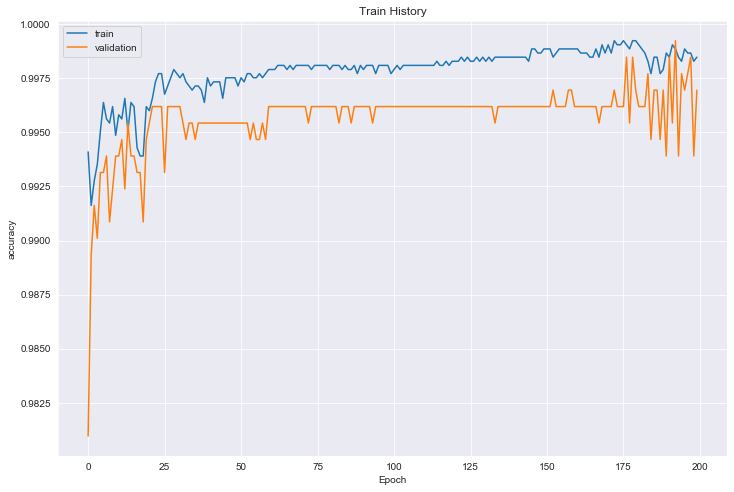

In [16]:
show_train_history(history,'accuracy','val_accuracy')

Já no que toca à curva da *loss*, é notório que o valor desce de forma adequada à medida que o treino é efetuado, não apresentando sinais de *overfitting*.

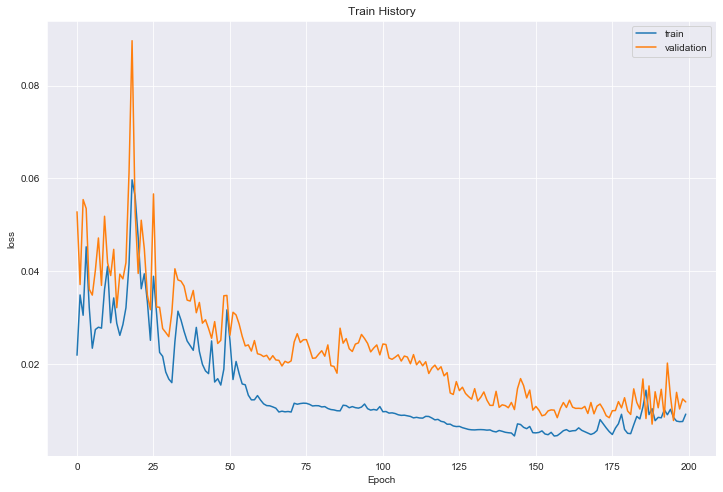

In [17]:
show_train_history(history,'loss','val_loss')

### Teste

Para testar o modelo treinado, é necessário modificar a forma do conjunto de teste, da mesma forma que o de treino foi inicialmente modificado.

In [18]:
X = teste.loc[:, teste.columns != 'LABEL']
x_test = X.values.reshape(X.shape[0], 1, X.shape[1])
Y = teste['LABEL']

# One Hot Encoding
y_test = to_categorical(Y.values)
y_test = y_test[:, 1:]

Tendo em conta o armazenamento do melhor modelo, este deve ser carregado numa variável para o teste dos dados ser efetuado.

In [19]:
model = load_model('best_model.pkl')

Efetuada a previsão do conjunto de treino, tendo em conta que as variáveis de decisão são categóricas, estas têm que ser convertidas de modo a ser efetuada uma comparação com os valores reais.

In [25]:
from sklearn.metrics import accuracy_score, classification_report
test_preds = model.predict_classes(x_test)
test_preds = to_categorical(test_preds)

Observando as métricas, é possível observar que a métrica de precisão na classe minoritária é 0.5 e o *recall* 0.6. Além disso, a precisão geral do modelo para o conjunto de teste é de 99.12%.

In [26]:
print(classification_report(y_test, test_preds))
accuracy_score(y_test, test_preds)

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       565
           1       0.50      0.60      0.55         5

   micro avg       0.99      0.99      0.99       570
   macro avg       0.75      0.80      0.77       570
weighted avg       0.99      0.99      0.99       570
 samples avg       0.99      0.99      0.99       570



0.9912280701754386

Pela análise das matrizes de confusão de ambas as classes, é visível que o modelo classificou corretamente 3 dos 5 sistemas com exoplanetas. É, também, importante mencionar que classificou como possuindo exoplanetas 3 sistemas de forma errada. Apesar destas falhas, este tipo de rede mostra potencial, pelo que deve ser explorada em mais detalhe.

In [27]:
from sklearn.metrics import multilabel_confusion_matrix
multilabel_confusion_matrix(y_test, test_preds)

array([[[  3,   2],
        [  3, 562]],

       [[562,   3],
        [  2,   3]]])